Testing climbing hold color identification using a kmean clustering of pixels within each bounding box of holds.  

Source:  
https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71   

https://stackoverflow.com/questions/2453344/find-the-colour-name-from-a-hexadecimal-colour-code/65074672#65074672  
https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python  

RGB/hex doesn't make sense to me. Example: (30,30,30)=gray (30,30,35)=blue.  
Thus, HSL or HSV seems like a better guess.    

CV2 has - COLOR_RGB2HSV and COLOR_RGB2HLS (or COLOR_BGR2HXX), and reverse.  
COLOR_RGB2HLS uint8 behaviour - [R,G,B] -> [0<H<180, 0<L<255, 0<S<255].  
so conversion from HLS classic values to function returned values - Hx0.5, Lx2.55, Sx2.55.  
https://docs.opencv.org/3.4.6/de/d25/imgproc_color_conversions.html  
In the future, I might want to set different weights to the different channels, to gain weighted sensitivity of the euclidean distance.

HSV:  
Hue - the dominant color perceived.  
Sauturation - the amount of white light mixed with the hue.  
Value - chromatic notion of intensity. Lower is blacker, higher is more similar to color.  

HSL:  
Hue - the dominant color.   
Saturation - purity of the color - low is grayer.   
Lightness/luminosity - Low black and high white.  

Maybe(?) gray is easier to define in HSL than HSV.  

Even if doing euclidean distance and not range per color, might be better to have two values per color, and if exceptions for black, white, and gray.

RGB TO HSL converter:  
https://www.rapidtables.com/convert/color/rgb-to-hsl.html

In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches 

import cv2
#import colorsys


import numpy as np
from collections import Counter#, OrderedDict
#from skimage.color import rgb2lab, deltaE_cie76
import os
from glob import glob
import pandas as pd
import time

from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
## values to multiply to convert HSL classic values to CV2 uint8 format of HLS (explained above)
hls2cv2hls = [0.5,2.55,2.55]

## give H,L,S weights - e.g. make hue count more when calculating euc dist.
## only applied when calculating euc distance, not for kmeans
hls_weights = [1.4,0.5,0.5]

## Define template colors:

In [3]:
##### color numbers were defined/annotated in master thesis work.
##### I linked color to number by running the code below first to view the images and corresponding colors. ####

# construct color info:

## image 0119 has two wrong annotations - 9 should be changed to 12
## I think image 0148 might have two wrong annotations 11 - might be violet or black.
## volumes are annotated as black

## Beta7 colors:
## black, forest, gray, green, red, violet, cornflower, blue, orange, pink, white, yellow
## NAVY, 
## MULTICOLOR - BROWN-BLACK, BLACK-WHITE, VIOLET-WHITE, RAINBOW?

color_dict = {
    0:'black',
    1:'brown',
    2:'forest',
    5:'gray',
    6:'green',
    7:'red',
    9:'violet',
    10:'cornflower',
    11:'blue', 
    12:'orange',
    14:'pink',
    15:'white', ## Includes dual white violet in image 0149 - those are usually violet routes??
    16:'yellow',
}

In [4]:
## notice that its L then S
## need to think about the circular nature of H (360=0), especially for red-ish hues. 
## Done manually - need to refine.

hls_dict = {
    'black': (180, 0, 50), ## black is defined by L=0, no matter the HS, so for now center values.
    'brown': (360, 25, 25),
    'forest': (135,20,25),
    'gray': (180, 50, 0), ## gray is S=0, L will effect the lightness, H has no effect
    'green': (128, 50, 75),
    'red': (360, 40, 65), ## 0=360!! need to correct in the future.
    'violet': (280, 50, 65),
    'cornflower': (185, 65, 65),
    'blue': (235, 40, 100), 
    'orange': (25, 70, 100),
    'pink': (310, 50, 100),
    'white': (180, 100, 50), ## white is defined by L=100, no matter the HS, so for now center values.
    'yellow': (50, 50, 100),
}

In [5]:
# template color dataframe - will build up in the future..
df_template_color = pd.DataFrame(color_dict.items(), columns=["index","name"])
df_template_color['hls'] = df_template_color["name"].map(hls_dict)
df_template_color

,index,name,hls
0,0,black,"(180, 0, 50)"
1,1,brown,"(360, 25, 25)"
2,2,forest,"(135, 20, 25)"
3,5,gray,"(180, 50, 0)"
4,6,green,"(128, 50, 75)"
5,7,red,"(360, 40, 65)"
6,9,violet,"(280, 50, 65)"
7,10,cornflower,"(185, 65, 65)"
8,11,blue,"(235, 40, 100)"
9,12,orange,"(25, 70, 100)"


In [6]:
## create color matrix from the template colors.
## will be used to compare euclidean distance to detected color of hold.
## format: [[color1_H,color1_L,color1_S],[color2_H,color2_L,color2_S],...]
hls_mat_for_euc = np.asarray(df_template_color.hls.tolist())#, dtype=np.uint16)
hls_mat_for_euc.shape

(13, 3)

In [9]:
## convert template values:
hls_mat_for_euc = (hls_mat_for_euc*hls2cv2hls*hls_weights).astype(np.uint8)

In [11]:
%%timeit
## test time of comparing a color's euclidean distance to template mat,
## Then get the location of the min distance in matrix rows
hls_exmple = np.array([160,50,50])
np.argmin(np.linalg.norm(hls_exmple - hls_mat_for_euc, axis=1))

10.8 µs ± 69 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Import and prepare image

In [12]:
imgs_path = 'thesis_raw_data'
color_path = os.path.join(imgs_path, 'color')

In [13]:
color_img_nums = [os.path.basename(f)[:-4] for f in glob(os.path.join(color_path,'*.jpg'))]

In [14]:
df = pd.read_csv('training_climbing_hall_raw.csv', converters={'image': lambda x: str(x)})

In [15]:
def import_img_color_and_bbox(img_num):
    
    print('image number:', img_num)
    # import img
    img = cv2.imread(os.path.join(color_path, f'{img_num}.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get all bounding boxes - from non color annotation:
    df_img = df[df.image.str.contains(img_num)]
    # get number of holds in image:
    print('n holds:', df_img.shape[0])
    
    # Import color annotation:
    df_img_color = pd.read_csv(os.path.join(color_path, f'{img_num}.txt'), sep=' ', 
                       names=['color_num', 'x_center','y_center','height','width'])
    print('n holds color annotation:', df_img_color.shape[0])
    
    ## convert bounding box info from (normalized) center and size to min and max:
    df_img_color["xmin"] = ((df_img_color["x_center"] - 
                             df_img_color["height"]/2)*img.shape[0]).astype('int')
    df_img_color["ymin"] = ((df_img_color["y_center"] - 
                             df_img_color["width"]/2)*img.shape[1]).astype('int')
    df_img_color["xmax"] = ((df_img_color["x_center"] + 
                             df_img_color["height"]/2)*img.shape[0]).astype('int')
    df_img_color["ymax"] = ((df_img_color["y_center"] + 
                             df_img_color["width"]/2)*img.shape[1]).astype('int')
    
    # create an image per hold bounding box:
    hold_imgs = [img[df_img_color.at[i,"ymin"]:df_img_color.at[i,"ymax"], 
                     df_img_color.at[i,"xmin"]:df_img_color.at[i,"xmax"]] 
                 for i in df_img_color.index]
    
    hold_imgs_hls = [cv2.cvtColor(hold_img, cv2.COLOR_RGB2HLS) for hold_img in hold_imgs]
    ## I MIGHT WANT TO ADD A STEP HERE TO MANIPULATE THE WEIGHTS OF HLS BY SETTING DIFFERENT RANGES.
    ## SO THE EUCLIDEAN DISTANCE WOULD HAVE DIFFERENT SENSITIVITY TO THE DIFFERENT CHANNELS.
    ## IF SO NEED TO APPLY TO TEMPLATE COLOR VALUES AS WELL.
    
    return img, df_img_color, hold_imgs, hold_imgs_hls
                     

In [16]:
def show_img(img, df_img_color):

    fig, ax = plt.subplots(figsize=(10, 6))

    ## draw bounding boxes:
    ax.imshow(img)
    ax.text(40,40, img.shape, color='red', size=20)
    ax.axis('off')

    for ii in df_img_color.index:

        rect = patches.Rectangle((df_img_color.at[ii,"xmin"], df_img_color.at[ii,"ymin"]), 
                               df_img_color.at[ii,"xmax"]-df_img_color.at[ii,"xmin"], 
                                 df_img_color.at[ii,"ymax"]-df_img_color.at[ii,"ymin"],
                               linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # add hold color text
        ax.text(df_img_color.at[ii,"xmin"], df_img_color.at[ii,"ymin"], 
                df_img_color.at[ii,'color_num'], size=13)

image number: 0105
n holds: 32
n holds color annotation: 33


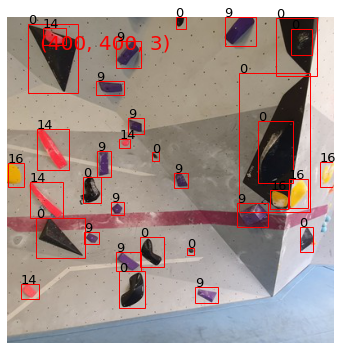

In [17]:
for i in range(5,6):
    img, df_img_color, hold_imgs, hold_imgs_hls = import_img_color_and_bbox(color_img_nums[i])
    show_img(img, df_img_color)


#### Get times of above actions

In [18]:
img.dtype

dtype('uint8')

In [19]:
%%timeit
## create individual hold images
hold_imgs = [img[df_img_color.at[i,"ymin"]:df_img_color.at[i,"ymax"], 
                 df_img_color.at[i,"xmin"]:df_img_color.at[i,"xmax"]] 
             for i in df_img_color.index]

480 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
%%timeit
# Time converting the entire image to HLS
temp = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

389 µs ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%timeit
## time converting hold bounding box images to HLS
temp = [cv2.cvtColor(hold_img, cv2.COLOR_RGB2HLS) for hold_img in hold_imgs]

238 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


so it's faster to to convert only the bounding boxes.

## METHOD I - Identify each hold color
Process:  
1. For each hold bounding box, get means of kmeans clusters.
2. Calculate euclidean distance of the mean colors to all template colors (can include more than one color per template color).

* Need to see how to deal with wall color - for now, gray is background, but thats gym specific. Example of wall at Arkose Marseille https://photos.app.goo.gl/5p8BDM1MX5T9KmW5A - gray (yellowish in photo) are volumes (wat.).
* Need to see how I choose the final color out of the k colors (and k?).
* Need to see how to optimize the template colors - maybe ranges instead of distance, thus allowing for different distances.


#### Def kmeans cluster

In [22]:
def get_kmeans_colors(image, n_colors=3):
    
    kmeans = KMeans(n_clusters=n_colors)
    image = image.reshape(image.shape[0]*image.shape[1], 3)

    labels = kmeans.fit_predict(image)
    counts = Counter(labels)
    center_colors = kmeans.cluster_centers_.astype(np.uint8)

    #ordered_colors = [center_colors[i] for i in counts.keys()]
    
    return center_colors, list(counts.values())

In [23]:
%%timeit
# test kmean function - one hold
get_kmeans_colors(hold_imgs_hls[0])

165 ms ± 4.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
print('hold img size', hold_imgs_hls[0].shape)

hold img size (35, 39, 3)


#### compute kmeans and closest template color

In [45]:
# ## for testing
# import math
# def calc_euc(center_color):
#     for it in hls_mat_for_euc:
#         print(math.sqrt((it[0]-center_color[0])**2 + 
#                         (it[1]-center_color[1])**2 +  
#                         (it[2]-center_color[2])**2))

In [75]:
center_colors

array([[  9, 144,  94],
       [128,  86,  18],
       [129, 207,  30]], dtype=uint8)

In [107]:
%%time
print(f'number of holds: {len(hold_imgs_hls)}')
print(f'number of template colors: {df_template_color.shape[0]}')

kmean_results = []

for im in hold_imgs_hls:
    center_colors, counts = get_kmeans_colors(im)
    
#     ## ifs for black, white, gray - 
#     ## need to define this better, just for now:
###### first figure out the conversion and values
#     center_colors = [(np.array([180, 0, 50])*hls2cv2hls).astype(np.uint8)  
#                      if c[1]<=5 else c
#                      for c in center_colors] # black
#     center_colors = [(np.array([180, 100, 50])*hls2cv2hls).astype(np.uint8)
#                      if c[1]>=150 else c
#                      for c in center_colors] # white
#     center_colors = [(np.array([180, 50, 0])*hls2cv2hls).astype(np.uint8)
#                      if c[2]<=5 else c
#                      for c in center_colors] # gray
    
    center_colors_weighted = [c*hls_weights for c in center_colors]
    best_matches_idx = [np.argmin(np.linalg.norm(c - hls_mat_for_euc, axis=1)) 
                        for c in center_colors_weighted]
    best_matches_name = [df_template_color.at[m,'name'] for m in best_matches_idx]
    
    kmean_results.append([center_colors, counts, best_matches_name])

number of holds: 33
number of template colors: 13
CPU times: user 3min 3s, sys: 1min 14s, total: 4min 17s
Wall time: 7.83 s


#### visualize results

In [108]:
def RGB2HEX(rgb_color):
    return "{:02x}{:02x}{:02x}".format(int(rgb_color[0]), int(rgb_color[1]), int(rgb_color[2]))

In [109]:
def HLS_str(hls_color):
    hls_color= (hls_color/hls2cv2hls).astype(np.uint16)
    return ",".join(str(c) for c in hls_color)

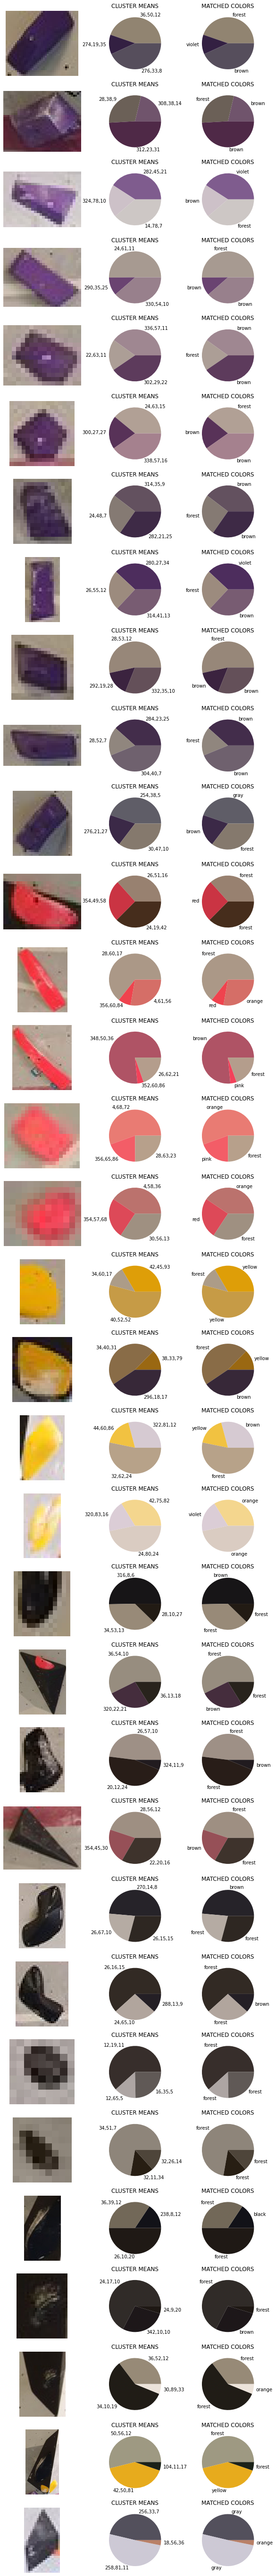

In [110]:
fig,ax = plt.subplots(len(hold_imgs), 3, figsize=(10,100))

for i,im in enumerate(hold_imgs):
    
    ax[i,0].imshow(im)
    
#     # Not true for all gyms, but for now delete gray:
#     color_names = [cn for cn in color_names if cn!='gray']
#     vals = [vals[ic] for ic,cn in enumerate(color_names) if cn!='gray']
#     hex_colors = [hex_colors[ic] for ic,cn in enumerate(color_names) if cn!='gray']
    
    center_colors_rgb = [cv2.cvtColor((c.reshape([1,1,3])), cv2.COLOR_HLS2RGB)[0][0] for c in kmean_results[i][0]]
    hex_colors = [f'#{RGB2HEX(c)}' for c in center_colors_rgb]
    center_colors_hls_str = [HLS_str(c) for c in kmean_results[i][0]]
    ax[i,1].pie(kmean_results[i][1], labels=center_colors_hls_str, colors=hex_colors)
    ax[i,1].set_title('CLUSTER MEANS')
    
        
    labels = [r for r in kmean_results[i][2]]
    ax[i,2].pie(kmean_results[i][1], labels=labels, colors=hex_colors)
    ax[i,2].set_title('MATCHED COLORS')
    
    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')
